In [49]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import cv2
from pathlib import Path

In [50]:
from IPython.display import display
from PIL import Image

def pic_show(img: np.ndarray):
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img)
    display(pil_img)

In [51]:
from utils.utils import DATA_SET

ds_name, radius = DATA_SET[8]
root = Path.cwd()
wd = root / ('data/train/' + ds_name)
img_dir = wd / '02'
seg_dir = wd / '02_ST/SEG'
tra_dir = wd / '02_GT/TRA'

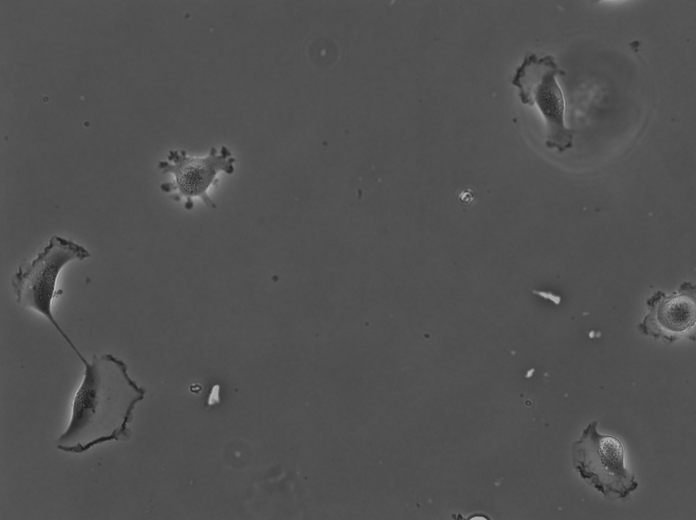

In [52]:
img_name = random.choice([f for f in img_dir.glob('*')])
seg_name = seg_dir / ('man_seg' + img_name.name[1:])
tra_name = tra_dir / ('man_track' + img_name.name[1:])
img = tifffile.imread(str(img_name))
seg = tifffile.imread(str(seg_name))
tra = tifffile.imread(str(tra_name))
seg_bin = 255 * np.uint8(seg > 0)
tra_bin = 255 * np.uint8(tra > 0)
# cv2.imshow('image', np.hstack((img, 255 * (mask / mask.max()))))
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# im_list = [img, seg_bin, tra_bin]
# fig, axs = plt.subplots(1, len(im_list))
# for i in range(len(im_list)):
#     axs[i].imshow(im_list[i])
#     axs[i].set_xticks([])
#     axs[i].set_yticks([])
# plt.show()
pic_show(img)

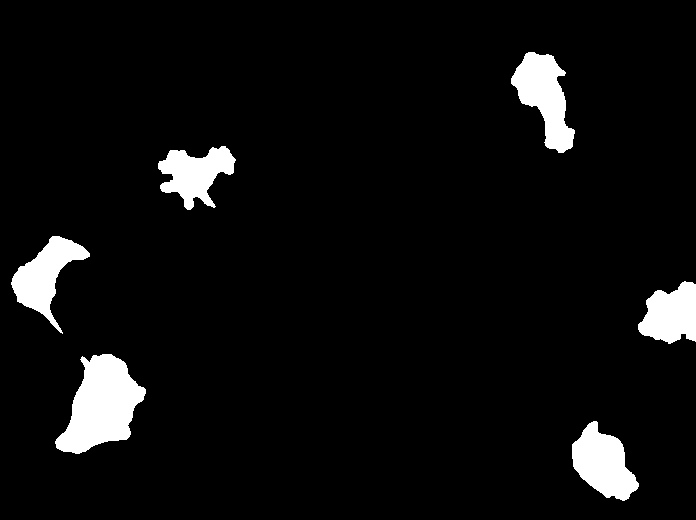

In [53]:
pic_show(seg_bin)

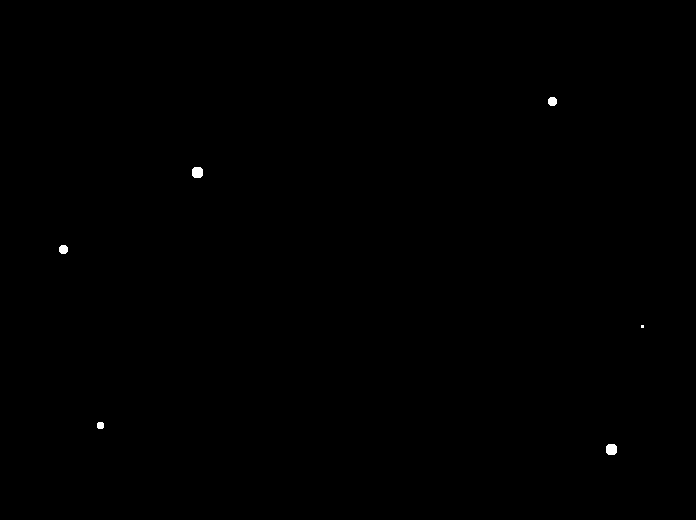

In [54]:
pic_show(tra_bin)

In [55]:
def stat(im):
    s = pd.Series(np.bincount(im.flatten()))
    return s[s != 0]
stat(tra)

0     361510
1         69
3        109
4         69
6          9
11       109
14        45
dtype: int64

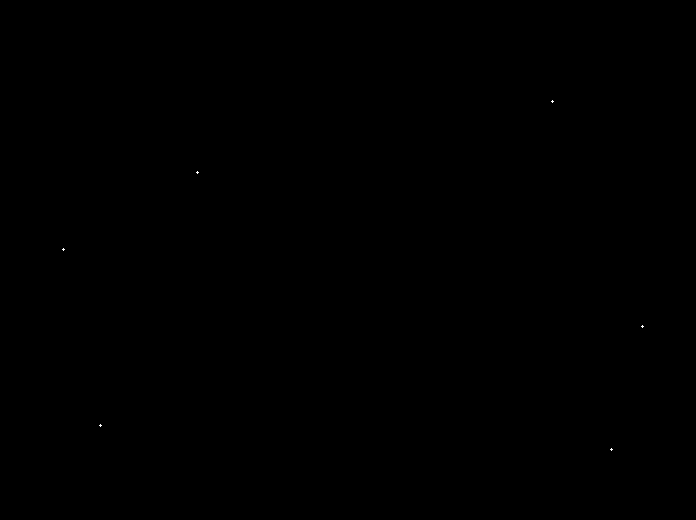

In [56]:
cnts, hier = cv2.findContours(tra_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
det_bin = np.zeros_like(tra_bin)
for cnt in cnts:
    M = cv2.moments(cnt)
    if M['m00'] != 0:
        center = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
    else:
        while isinstance(cnt[0], np.ndarray):
            cnt = cnt[0]
        center = cnt
    cv2.circle(det_bin, center, 1, 255, -1)
pic_show(det_bin)

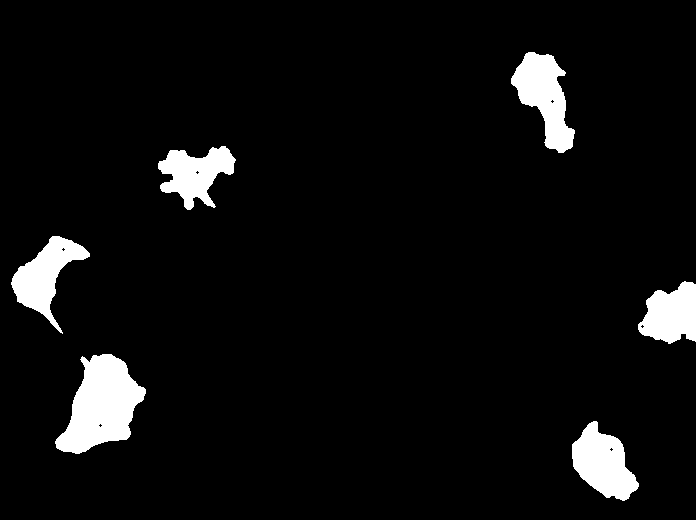

In [57]:
diff = cv2.absdiff(seg_bin, det_bin)
pic_show(diff)

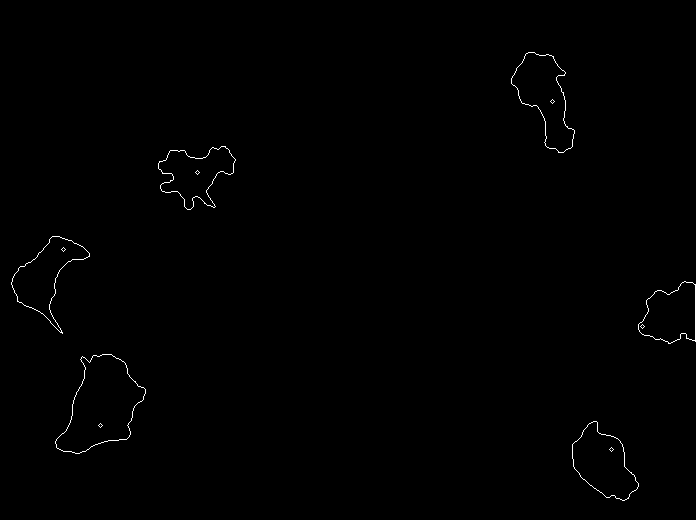

In [58]:
cnts, hier = cv2.findContours(diff, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
res = np.zeros_like(diff)
cv2.drawContours(res, cnts, -1, 255, 1)
pic_show(res)

In [59]:
hier = np.squeeze(hier)
hier

array([[ 2, -1,  1, -1],
       [-1, -1, -1,  0],
       [ 4,  0,  3, -1],
       [-1, -1, -1,  2],
       [ 6,  2,  5, -1],
       [-1, -1, -1,  4],
       [ 8,  4,  7, -1],
       [-1, -1, -1,  6],
       [10,  6,  9, -1],
       [-1, -1, -1,  8],
       [-1,  8, 11, -1],
       [-1, -1, -1, 10]], dtype=int32)

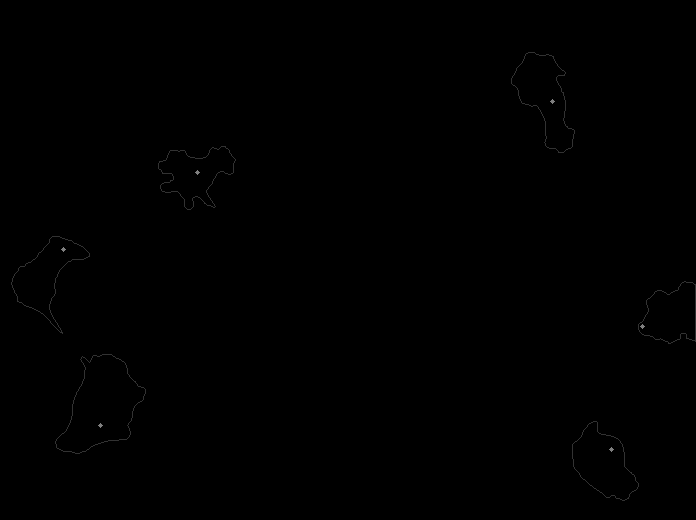

In [60]:
det_mask = np.zeros_like(diff)
seg_mask = np.zeros_like(diff)
for i in range(len(cnts)):
    first_child = hier[i, -2]
    parent = hier[i, -1]
    if first_child != -1:
        next_child = hier[first_child, 0]
        if next_child != -1:
            cv2.drawContours(det_mask, cnts, first_child, 255, -1)
            cv2.drawContours(det_mask, cnts, next_child, 255, -1)

            cv2.drawContours(seg_mask, cnts, i, 255, -1)
        else:
            cv2.drawContours(det_mask, cnts, first_child, 127, -1)

            cv2.drawContours(seg_mask, cnts, i, 127, -1)
        cv2.drawContours(det_mask, cnts, i, 50, 1)
    elif parent == -1:
        cv2.drawContours(det_mask, cnts, i, 127, -1)
pic_show(det_mask)

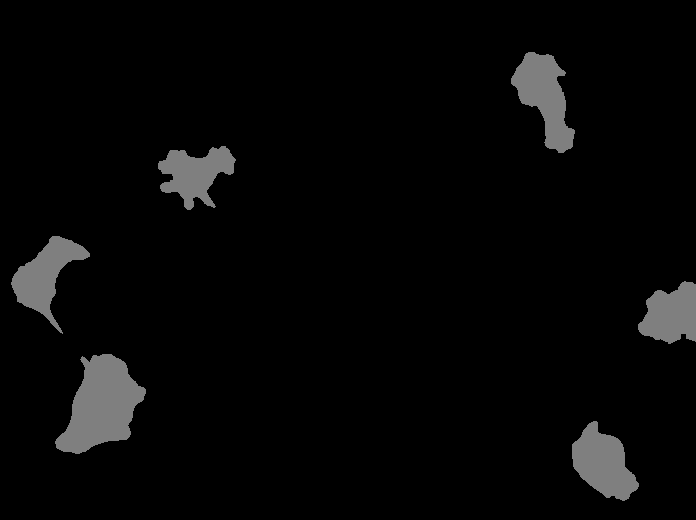

In [61]:
pic_show(seg_mask)

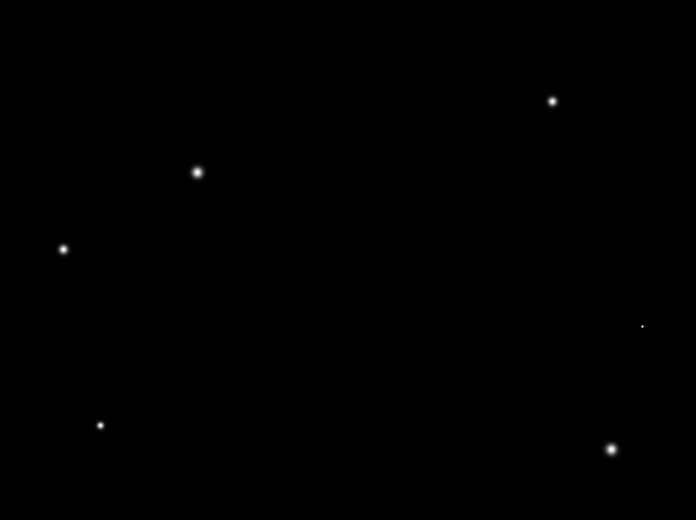

In [62]:
from utils.data_loading import CTCDataset

# mask = np.stack((seg, tra), axis=-1)
det_mask = CTCDataset.preprocess(tra, -1, flag='det_mask', radius=radius)
# seg_mask, det_mask = mask_pred[0, ...], mask_pred[1, ...]
pic_show(np.uint8(det_mask * 255))

In [63]:
det_mask.max()

1.0

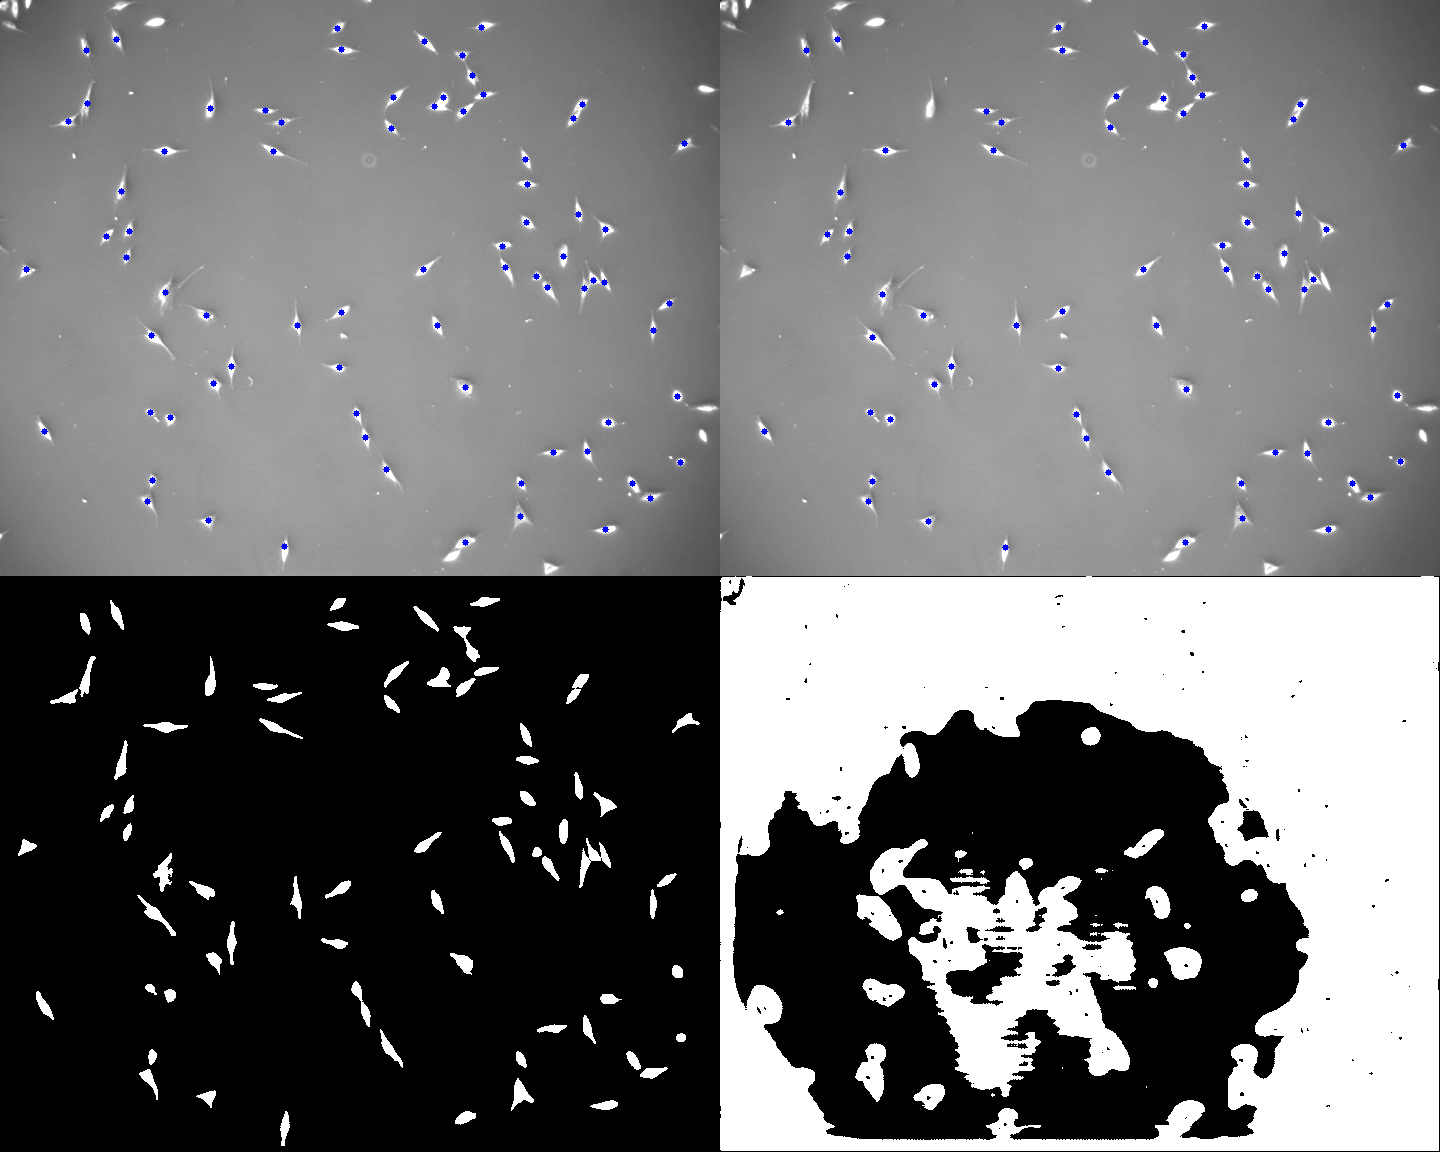

In [64]:
pred = cv2.imread(str(root / 'pred.bmp'), -1)
pic_show(pred)